In [0]:
import zipfile

In [0]:
zip_ref = zipfile.ZipFile("/content/drive/My Drive/HAR data/HumanActivityRecognition.zip", 'r')
zip_ref.extractall("/content/drive/My Drive/HAR data")
zip_ref.close()

In [0]:
import pandas as pd
import numpy as np

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [0]:
# Data directory
DATADIR = '/content/drive/My Drive/HAR data/HAR/UCI_HAR_Dataset'

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'/content/drive/My Drive/HAR data/HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'/content/drive/My Drive/HAR data/HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [0]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [0]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [0]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

# Train Test Split

In [0]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [18]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


# Store into pickle  

In [0]:
%%time
import pickle   
    
dbfile_1 = open('/content/drive/My Drive/HAR data/Xtrain', 'ab') 
dbfile_2 = open('/content/drive/My Drive/HAR data/Xtest', 'ab') 
dbfile_3 = open('/content/drive/My Drive/HAR data/ytrain', 'ab') 
dbfile_4 = open('/content/drive/My Drive/HAR data/ytest', 'ab') 
      
# source, destination 
pickle.dump(X_train, dbfile_1) 
pickle.dump(X_test, dbfile_2) 
pickle.dump(Y_train, dbfile_3) 
pickle.dump(Y_test, dbfile_4) 

dbfile_1.close()
dbfile_2.close()
dbfile_3.close()
dbfile_4.close()

CPU times: user 128 ms, sys: 65 ms, total: 193 ms
Wall time: 356 ms


In [0]:
'''import pickle  
dbfile_1 = open('/content/drive/My Drive/HAR data/Xtrain', 'rb')      
X_train = pickle.load(dbfile_1) 
dbfile_1.close()

dbfile_2 = open('/content/drive/My Drive/HAR data/Xtest', 'rb')      
X_test = pickle.load(dbfile_2) 
dbfile_2.close()

dbfile_3 = open('/content/drive/My Drive/HAR data/ytrain', 'rb')      
Y_train = pickle.load(dbfile_3) 
dbfile_3.close()

dbfile_4 = open('/content/drive/My Drive/HAR data/ytest', 'rb')      
Y_test = pickle.load(dbfile_4) 
dbfile_4.close()'''

# Model 1
* Defining the Architecture of LSTM

In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 92s 13ms/step - loss: 1.3018 - acc: 0.4395 - val_loss: 1.1254 - val_acc: 0.4662
Epoch 2/30
7352/7352 [==============================] - 94s 13ms/step - loss: 0.9666 - acc: 0.5880 - val_loss: 0.9491 - val_acc: 0.5714
Epoch 3/30
7352/7352 [==============================] - 97s 13ms/step - loss: 0.7812 - acc: 0.6408 - val_loss: 0.8286 - val_acc: 0.5850
Epoch 4/30
7352/7352 [==============================] - 95s 13ms/step - loss: 0.6941 - acc: 0.6574 - val_loss: 0.7297 - val_acc: 0.6128
Epoch 5/30
7352/7352 [==============================] - 92s 13ms/step - loss: 0.6336 - acc: 0.6912 - val_loss: 0.7359 - val_acc: 0.6787
Epoch 6/30
7352/7352 [==============================] - 94s 13ms/step - loss: 0.5859 - acc: 0.7134 - val_loss: 0.7015 - val_acc: 0.6939
Epoch 7/30
7352/7352 [==============================] - 95s 13ms/step - loss: 0.5692 - acc: 0.7477 - val_loss: 0.5995 - val_acc: 0.7387


In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 512        0        25        0                   0   
SITTING                  3      410        75        0                   0   
STANDING                 0       87       445        0                   0   
WALKING                  0        0         0      481                   2   
WALKING_DOWNSTAIRS       0        0         0        0                 382   
WALKING_UPSTAIRS         0        0         0        2                  18   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            3  
STANDING                           0  
WALKING                           13  
WALKING_DOWNSTAIRS                38  
WALKING_UPSTAIRS                 451  


In [0]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 4s 2ms/step


In [0]:
score

[0.3087582236972612, 0.9097387173396675]

# Model 2

In [30]:
# With One LSTM Layer Model 1  

model = Sequential()

# 1 LSTM layer
model.add(LSTM(n_hidden, input_shape = (timesteps, input_dim))) 
model.add(Dropout(0.25))
model.add(Dense(n_classes, activation = 'relu'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=64,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 10s 1ms/step - loss: 0.6114 - acc: 0.8331 - val_loss: 0.4062 - val_acc: 0.8537
Epoch 2/30
7352/7352 [==============================] - 9s 1ms/step - loss: 0.3978 - acc: 0.8531 - val_loss: 0.3853 - val_acc: 0.8613
Epoch 3/30
7352/7352 [==============================] - 9s 1ms/step - loss: 0.3711 - acc: 0.8528 - val_loss: 0.3690 - val_acc: 0.8606
Epoch 4/30
7352/7352 [==============================] - 9s 1ms/step - loss: 0.3640 - acc: 0.8465 - val_loss: 0.3767 - val_acc: 0.8463
Epoch 5/30
7352/7352 [==============================] - 9s 1ms/step - loss: 0.3483 - acc: 0.8488 - val_loss: 0.3553 - val_acc: 0.8466
Epoch 6/30
7352/7352 [==============================] - 10s 1ms/step - loss: 0.3224 - acc: 0.8537 - val_loss: 0.3445 - val_acc: 0.8430
Epoch 7/30
7352/7352 [==============================] - 10s 1ms/step - loss: 0.3085 - acc: 0.8558 - val_loss: 0.3386 - val_acc: 0.8489
Epoch 8/30


In [32]:
score = model.evaluate(X_test, Y_test)
print(score)

2947/2947 [==============================] - 1s 302us/step
[0.2719094553862105, 0.8700373047159452]


In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 506        0  ...                   4                27
SITTING                  0      222  ...                   0                26
STANDING                 0        9  ...                   0               111
WALKING                  0       28  ...                  28               184
WALKING_DOWNSTAIRS       0        6  ...                 363                26
WALKING_UPSTAIRS         0        0  ...                  40               428

[6 rows x 6 columns]


In [0]:
%matplotlib inline

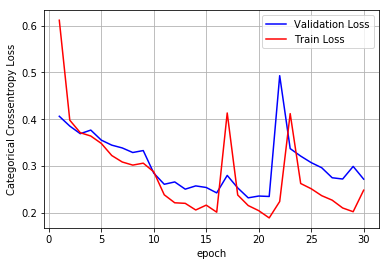

In [36]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

# Model 3

In [0]:
# With One LSTM Layer Model 1  # 
n_hidden = 80

model = Sequential()

# 1 LSTM layer
model.add(LSTM(n_hidden, input_shape = (timesteps, input_dim)))     # 1 LSTM

model.add(Dropout(0.25))
model.add(Dense(n_classes, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 80)                28800     
_________________________________________________________________
dropout_4 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 486       
Total params: 29,286
Trainable params: 29,286
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=64,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 31s 4ms/step - loss: 0.4190 - acc: 0.8390 - val_loss: 0.3644 - val_acc: 0.8571
Epoch 2/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.3535 - acc: 0.8616 - val_loss: 0.3331 - val_acc: 0.8613
Epoch 3/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.3183 - acc: 0.8736 - val_loss: 0.3162 - val_acc: 0.8704
Epoch 4/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.2887 - acc: 0.8776 - val_loss: 0.2728 - val_acc: 0.8806
Epoch 5/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.2342 - acc: 0.8948 - val_loss: 0.2279 - val_acc: 0.8955
Epoch 6/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.2182 - acc: 0.8994 - val_loss: 0.2412 - val_acc: 0.8933
Epoch 7/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.2087 - acc: 0.9015 - val_loss: 0.2105 - val_acc: 0.9009
Epoch 8

In [0]:
score = model.evaluate(X_test, Y_test)
print(score)

2947/2947 [==============================] - 8s 3ms/step
[0.09848940819087885, 0.9662934093908977]


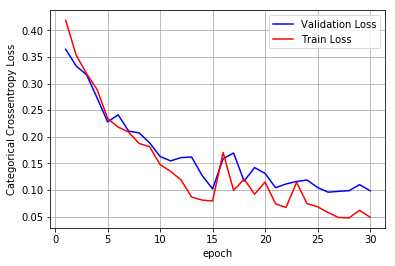

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

# Model 4

In [0]:
# With One LSTM Layer Model 1  # 
n_hidden = 80

model = Sequential()

# 1 LSTM layer
model.add(LSTM(n_hidden, input_shape = (timesteps, input_dim), return_sequences = True))     # 1 LSTM

model.add(Dropout(0.25))
model.add(LSTM(n_hidden)) 
model.add(Dense(n_classes, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
print(model.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 80)           28800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 80)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 486       
Total params: 80,806
Trainable params: 80,806
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
%%time
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size= 64,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 58s 8ms/step - loss: 0.0341 - acc: 0.9861 - val_loss: 0.0949 - val_acc: 0.9742
Epoch 2/30
7352/7352 [==============================] - 58s 8ms/step - loss: 0.0371 - acc: 0.9852 - val_loss: 0.1142 - val_acc: 0.9724
Epoch 3/30
7352/7352 [==============================] - 58s 8ms/step - loss: 0.0352 - acc: 0.9856 - val_loss: 0.1288 - val_acc: 0.9688
Epoch 4/30
7352/7352 [==============================] - 58s 8ms/step - loss: 0.0390 - acc: 0.9845 - val_loss: 0.0962 - val_acc: 0.9751
Epoch 5/30
7352/7352 [==============================] - 58s 8ms/step - loss: 0.0366 - acc: 0.9847 - val_loss: 0.1185 - val_acc: 0.9722
Epoch 6/30
7352/7352 [==============================] - 58s 8ms/step - loss: 0.0370 - acc: 0.9849 - val_loss: 0.1057 - val_acc: 0.9723
Epoch 7/30
7352/7352 [==============================] - 58s 8ms/step - loss: 0.0331 - acc: 0.9867 - val_loss: 0.1143 - val_acc: 0.9738
Epoch 8

In [0]:
score = model.evaluate(X_test, Y_test)
print(score)

2947/2947 [==============================] - 17s 6ms/step
[0.1007159318419772, 0.9716095518248745]


In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 511        0  ...                   0                 0
SITTING                  0      351  ...                   0                 2
STANDING                 0       22  ...                   1                 0
WALKING                  0        0  ...                  43                 1
WALKING_DOWNSTAIRS       0        0  ...                 420                 0
WALKING_UPSTAIRS         0        4  ...                  14               440

[6 rows x 6 columns]


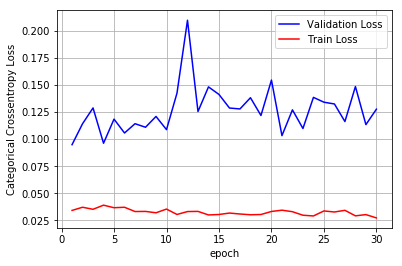

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

# Conclusion

In [3]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model","Hidden layer","activation","Optimizer", "Test accuracy in %"]

x.add_row(["Lstm + dropout(0.5)","32","sigmoid","rmsprop" ,"90.97%"])
x.add_row(["Lstm + dropout(0.25)","32","relu","Adam" ,"87%"])
x.add_row(["Lstm + dropout(0.25)","80","sigmoid" ,"Adam", "96.62%"])
x.add_row(["Lstm + dropout(0.25)","80","sigmoid","rmsprop" ,"97.16%"])


print(x)

+----------------------+--------------+------------+-----------+--------------------+
|        Model         | Hidden layer | activation | Optimizer | Test accuracy in % |
+----------------------+--------------+------------+-----------+--------------------+
| Lstm + dropout(0.5)  |      32      |  sigmoid   |  rmsprop  |       90.97%       |
| Lstm + dropout(0.25) |      32      |    relu    |    Adam   |        87%         |
| Lstm + dropout(0.25) |      80      |  sigmoid   |    Adam   |       96.62%       |
| Lstm + dropout(0.25) |      80      |  sigmoid   |  rmsprop  |       97.16%       |
+----------------------+--------------+------------+-----------+--------------------+


* By increasing the hidden layers to 80 we got a very good result. 
* Lstm + dropout(0.25) model ,with 80 hidden layers with "sigmoid" activation function we got a test acccuracy of 97.16%.
* We can further imporve the performace with Hyperparameter tuning.